This is the analysis that is captured in this doc: https://docs.google.com/document/d/1Ik8DfYVXTYEemgvqXsxwBwNqpsfskh2c3aSvIDOvXcQ/edit#. 

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from plotnine import *

### Load data and split by relationship

In [2]:
data_dir = '../data/fb13/'   

In [3]:
graph = pd.read_csv(f'{data_dir}/graph.txt', sep='\t', names=['e1', 'rel', 'e2'])
graph.rel.value_counts()

gender            66663
nationality       54451
profession        54182
place_of_death    40579
place_of_birth    37970
location          28783
institution       18358
cause_of_death    12857
religion           9635
parents            6268
children           6041
ethnicity          5622
spouse             4464
Name: rel, dtype: int64

In [33]:
parents = graph[graph.rel == 'parents']
children = graph[graph.rel == 'children']
spouses = graph[graph.rel == 'spouse']

### Question: for how many parent relationships is there an existing reciprocal children relationship?

In [5]:
reciprocal_count = 0
for i, row in parents.iterrows():
    c = children[children.e1 == row.e2]
    cc = c[c.e2 == row.e1]
    if cc.shape[0] == 1:
        reciprocal_count += 1
    else:
        assert cc.shape[0] == 0
print(f'{reciprocal_count} children relationships matching parent relationships')

5629 children relationships matching parent relationships


### Question: how many parents with children also have spouses in the database?

In [28]:
num_spouse_edges = []
for i, row in parents.iterrows():
    parent = row.e2
    s1 = spouses[spouses.e1 == parent]
    s2 = spouses[spouses.e2 == parent]
    n1 = s1.shape[0]
    n2 = s2.shape[0]
    print(f'{n1} in 1 ({s1.index}) and {n2} in 2 ({s2.index})')
    num_spouse_edges.append(n1+n2)
nspouse = np.array(num_spouse_edges)

n_with_spouse = len(np.where(nspouse > 0)[0])
ntotal = len(nspouse)
print(f'{n_with_spouse} out of {ntotal} parents have at least one spouse edge')

1 in 1 (Int64Index([199279], dtype='int64')) and 1 in 2 (Int64Index([262923], dtype='int64'))
1 in 1 (Int64Index([138597], dtype='int64')) and 0 in 2 (Int64Index([], dtype='int64'))
1 in 1 (Int64Index([313110], dtype='int64')) and 1 in 2 (Int64Index([275649], dtype='int64'))
1 in 1 (Int64Index([36247], dtype='int64')) and 0 in 2 (Int64Index([], dtype='int64'))
1 in 1 (Int64Index([207128], dtype='int64')) and 1 in 2 (Int64Index([152083], dtype='int64'))
0 in 1 (Int64Index([], dtype='int64')) and 0 in 2 (Int64Index([], dtype='int64'))
1 in 1 (Int64Index([209425], dtype='int64')) and 0 in 2 (Int64Index([], dtype='int64'))
0 in 1 (Int64Index([], dtype='int64')) and 0 in 2 (Int64Index([], dtype='int64'))
1 in 1 (Int64Index([76528], dtype='int64')) and 1 in 2 (Int64Index([62549], dtype='int64'))
0 in 1 (Int64Index([], dtype='int64')) and 0 in 2 (Int64Index([], dtype='int64'))
2 in 1 (Int64Index([152250, 270399], dtype='int64')) and 2 in 2 (Int64Index([22363, 137919], dtype='int64'))
0 in 1 (

### Among spouse relationships, how many are represented in both directions?

In [36]:
spouse_count = []
for i, row in spouses.iterrows():
    x = spouses[spouses.e1 == row.e2]
    xx = x[x.e2 == row.e1]
    spouse_count.append(xx.shape[0])

In [39]:
nspouse = np.array(spouse_count)
n_with_spouse = len(np.where(nspouse > 0)[0])
ntotal = len(nspouse)
print(f'{n_with_spouse} out of {ntotal} spouse edges are reciprocated')

4112 out of 4464 spouse edges are reciprocated


### How many different ethnicities exist in the data?

In [50]:
ethnic = graph[graph.rel == 'ethnicity']
ethnic.e2.value_counts()[:20]
len(set(ethnic.e2))

jew                  1417
african_american     1053
germans               324
scottish_people       211
poles                 156
irish_american        128
white_american        126
hungarian_people       95
italian_people         64
ashkenazi_jews         63
scottish_american      61
greeks                 57
french_people          47
english_people         46
caucasian_race         38
russians               38
korean_people          34
swedish_american       32
mexican_american       32
italian_american       31
Name: e2, dtype: int64

211

In [51]:
ethnic.shape

(5622, 3)

### Study nationality

In [182]:
nationality = graph[graph.rel == 'nationality']
nationality.e2.value_counts()[:50]

united_states               20712
germany                      5606
united_kingdom               4359
france                       3646
england                      3597
italy                        1886
canada                       1716
austria                      1014
netherlands                   986
spain                         816
russia                        781
india                         691
japan                         674
australia                     583
hungary                       555
scotland                      543
poland                        488
switzerland                   427
sweden                        334
portugal                      310
denmark                       261
china                         252
kingdom_of_england            243
belgium                       232
romania                       187
soviet_union                  177
argentina                     175
pakistan                      150
south_africa                  146
iran          

### Read FB13 graph into NetworkX object to explore

In [56]:
G = nx.Graph()
entities = pd.read_csv(f'{data_dir}/entity2id.txt', sep='\t', names=['name', 'id'])
e_tuples = [(row['id'], {"name": row['name']}) for i, row in entities.iterrows()]
e_dict = {row['name']: row['id'] for i, row in entities.iterrows()}
G.add_nodes_from(e_tuples)

for i, row in graph.iterrows():
    if i % 1000 == 0:
        print(i)
    G.add_edge(e_dict[row.e1], e_dict[row.e2], relation=row.rel)

### Plot degree distribution

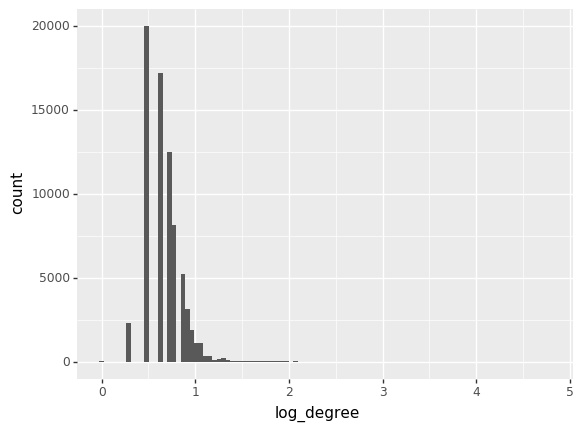

<ggplot: (-9223372036504874794)>

In [104]:
node_degrees = [{'node': n, 'degree': d, 'log_degree': np.log10(d)} for n, d in G.degree()]
deg = pd.DataFrame(node_degrees)
ggplot(deg, aes(x='log_degree')) + geom_histogram(bins=100)

In [145]:
deg.sort_values(by='degree', ascending=False, inplace=True)
deg.rename(columns={'node': 'id'}, inplace=True)
deg = deg.merge(entities, how='inner', on='id')

,node,degree,log_degree
33515,33515,58593,4.767846
28691,28691,20777,4.317583
6973,6973,8070,3.906874
11900,11900,5958,3.775100
32593,32593,5649,3.751972
...,...,...,...
5238,5238,1,0.000000
11612,11612,1,0.000000
36828,36828,1,0.000000
12721,12721,1,0.000000


### Look at what happens when you remove the top 100 most connected nodes

In [183]:
top_nodes = list(deg.loc[:100,'id'])

G2 = G.copy()
G2.remove_nodes_from(top_nodes)

nx.number_connected_components(G)
nx.number_connected_components(G2)

1

8667

You get 8667 distinct components!